In [1]:
import pandas as pd
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import requests
import urllib
import hashlib
import folium
from IPython.display import display

In [2]:
file_path = r"YOUR SAVING PATH"

In [3]:
df = pd.read_csv(file_path)
comments = df['Jobname']

In [4]:
df.isnull().sum()

Jobname       0
Jobcompany    0
Area          0
Salary        0
Jobcontent    0
dtype: int64

In [5]:
def chinese_tokenizer(text):
    return jieba.lcut(text)

tokenized_comments = comments.apply(chinese_tokenizer)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12933\AppData\Local\Temp\jieba.cache
Loading model cost 0.515 seconds.
Prefix dict has been built successfully.


In [6]:
word_counts = Counter([word for comment in tokenized_comments for word in comment])

In [7]:
wordcloud = WordCloud(
    font_path='msyh.ttc', 
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_counts)

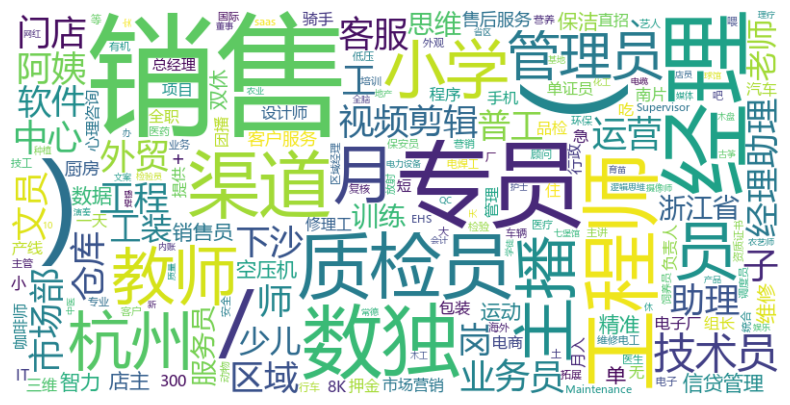

In [8]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
def salary_to_numeric(salary):
    salary = salary.replace('千', '')
    if '-' in salary:
        range_split = salary.split('-')
        if len(range_split) == 2:
            try:
                low, high = range_split
                return (float(low) + float(high)) / 2
            except ValueError:
                return np.nan
    return np.nan

df['salary_numeric'] = df['Salary'].apply(salary_to_numeric)


In [10]:
df.dropna(subset=['salary_numeric'], axis=0, inplace=True)

In [11]:
area_salary = df.groupby('Area')['salary_numeric'].mean().reset_index()

In [12]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 

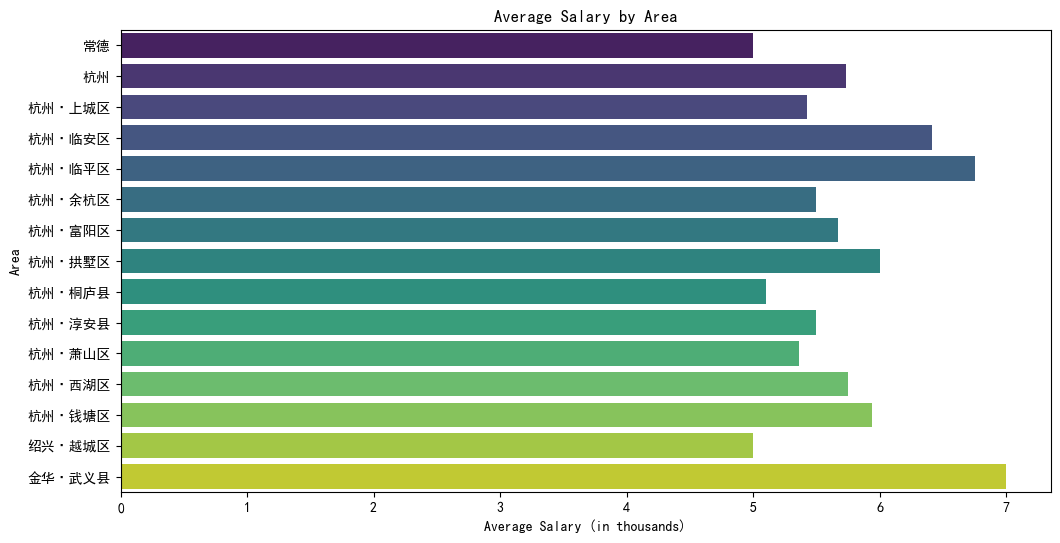

In [13]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='salary_numeric', y='Area', data=area_salary, palette='viridis',hue='Area')

ax.set_title('Average Salary by Area')
ax.set_xlabel('Average Salary (in thousands)')
ax.set_ylabel('Area')

plt.show()

In [34]:
host = "https://api.map.baidu.com"
uri = "/geocoding/v3"
ak = "YOUR BAIDU AK"
sk = "YOUR BAIDU SK"

latitudes = []
longitudes = []

for area in area_salary['Area']:
    params = {
        "address": area,
        "output": "json",
        "ak": ak,
    }
    
    paramsArr = []
    for key in params:
        paramsArr.append(f"{key}={params[key]}")
    
    queryStr = uri + "?" + "&".join(paramsArr)
    encodedStr = urllib.parse.quote(queryStr, safe="/:=&?#+!$,;'@()*[]")
    rawStr = encodedStr + sk
    sn = hashlib.md5(urllib.parse.quote_plus(rawStr).encode("utf8")).hexdigest()
    queryStr = queryStr + "&sn=" + sn
    url = host + queryStr
    
    response = requests.get(url)
    if response:
        data = response.json()
        if 'result' in data and 'location' in data['result']:
            latitudes.append(data['result']['location']['lat'])
            longitudes.append(data['result']['location']['lng'])
        else:
            latitudes.append(None)
            longitudes.append(None)
    else:
        latitudes.append(None)
        longitudes.append(None)

area_salary['Latitude'] = latitudes
area_salary['Longitude'] = longitudes

m = folium.Map(location=[35.8617, 104.1954], zoom_start=5)

for _, row in area_salary.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Area: {row['Area']}<br>Average Salary: {row['salary_numeric']}",
        tooltip=row['Area']
    ).add_to(m)

m.save("HangZhou_Average_Salary_Map.html")


In [36]:
html_file = r"YOUR SAVING PATH"

with open(html_file, 'r', encoding='utf-8') as f:
    html_content = f.read()

m.get_root().html.add_child(folium.Element(html_content))

display(m)

In [37]:
df['job_keywords'] = df['Jobname'].apply(lambda x: jieba.lcut(x)[0])

In [38]:
job_salary = df.groupby('job_keywords')['salary_numeric'].mean().reset_index()

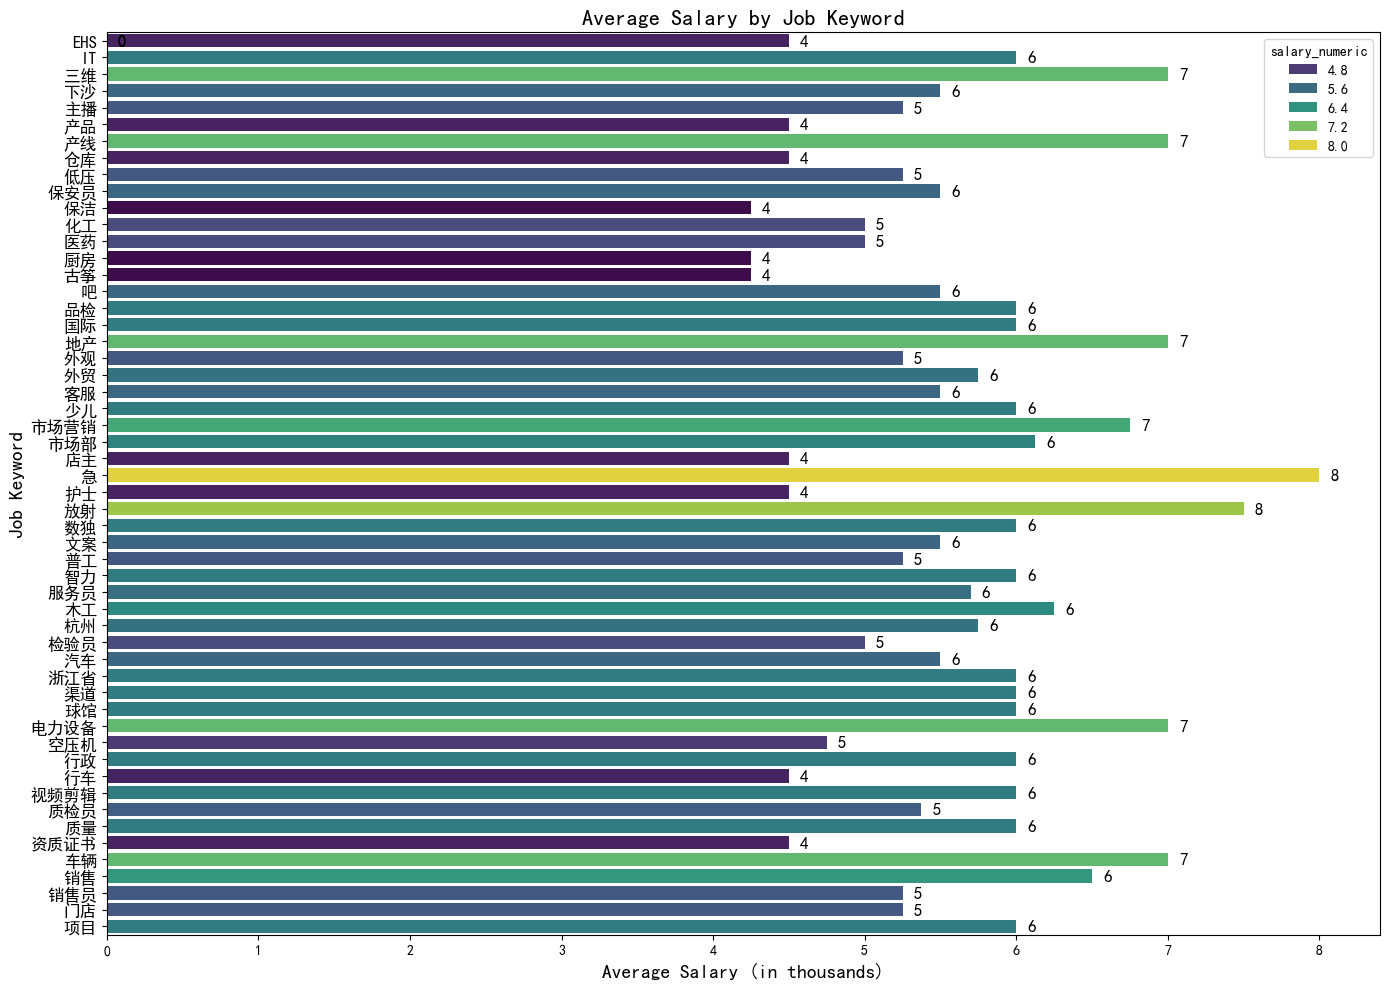

In [39]:
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='salary_numeric', y='job_keywords', data=job_salary, palette='viridis',hue='salary_numeric')

ax.set_title('Average Salary by Job Keyword', fontsize=16)
ax.set_xlabel('Average Salary (in thousands)', fontsize=14)
ax.set_ylabel('Job Keyword', fontsize=14)


plt.yticks(rotation=0, fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['job_keywords'])
y = df['salary_numeric']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [31]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 2.24
R^2 Score: -1.72


In [32]:
new_job_titles = ['销售', '外贸'] 
new_X = vectorizer.transform(new_job_titles)
predicted_salaries = model.predict(new_X)


In [33]:
for job, salary in zip(new_job_titles, predicted_salaries):
    print(f'预测职位 "{job}" 的工资为 {salary:.2f} 千元')

预测职位 "销售" 的工资为 6.50 千元
预测职位 "外贸" 的工资为 5.75 千元
